In [1]:
%matplotlib inline
import tensorflow as tf
from vahun.corpus import Corpus
import numpy as np
from vahun.tools import Timer
from vahun.tools import explog
from vahun.autoencoder import Autoencoder_ffnn
from vahun.genetic import evolution
from vahun.genetic import experiment
from vahun.tools import show_performance

encode=10
dictsize=200000
popsize=1


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction=1
corp_path='/home/velkey/corp/webkorpusz.wpl'
corp=Corpus(corpus_path=corp_path,
            needed_corpus=["hun_lower"],
            language="Hun",size=dictsize,encoding_len=10)
database=corp.hun_lower
all_features=corp.featurize_data_charlevel_onehot(database)
train=all_features[0:int(len(all_features)*0.8)]
test=all_features[int(len(all_features)*0.8):len(all_features)]
x_train = train.reshape((len(train), np.prod(train.shape[1:])))
x_test = test.reshape((len(test), np.prod(test.shape[1:])))
print(x_train.shape)

logger=explog(encoder_type="Demo_"+str(encode),
              encoding_dim=encode,feature_len=10,
              lang="Hun",unique_words=len(set(database)),
              name="demo_autoencoder_"+str(encode),population_size=popsize,
              words=len(corp.hun_lower))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

exp=experiment(encoded_width=10,layermax=10,layermin=2,maxw=10,minw=3,out_dim=360)
exp.weights=[348, 254, 10, 254, 348, 360]
exp.len=len(exp.weights)

Corpus initalized, fields: ['hun_lower'] 
Unique words:  43509
(102731, 360)


In [2]:
encoder=Autoencoder_ffnn(experiment=exp,
                 logger=logger,tf_session=sess,
                 inputdim=360,
                 layerlist=exp.weights,
                 encode_index=int(exp.len/2-1),
                 optimizer =tf.train.AdamOptimizer(learning_rate = 0.001),
                 nonlinear=tf.sigmoid)

In [3]:
encoder.train(x_train,x_test,512,50)

         a 	          a
    magyar 	     magyar
 ferdinánd 	  melyázány
     által 	      által
        az 	         az
   osztrák 	    aurtják
   kormány 	    tormány
  császári 	   kssátári
 augusztus 	  karosztus
emlékirata 	 halztozata
         a 	          a
pragmatica 	  ealtatája
sanctióval 	 kelyásával
        és 	         és
        az 	         az
  áprilisi 	   kitolási
         s 	          s
        az 	         az
    önálló 	     aválló
    magyar 	     magyar
        és 	         és
  hadügyek 	   kemélyek
követelése 	 keletelése
   mellett 	    mellett
  kétségbe 	   kérzénbe
     vonta 	      tolta
         a 	          a
    nyarán 	     ssarán
    önálló 	     aválló
      való 	       való
     jogát 	      soját
        is 	         is
        az 	         az
  fordulat 	   portálat
     immár 	        már
    idején 	     izekén
 batthyány 	  eatsotány
        és 	         és
      deák 	        túk
     éppen 	      éppen
   bécsben 	    kénzben
      hogy 	    

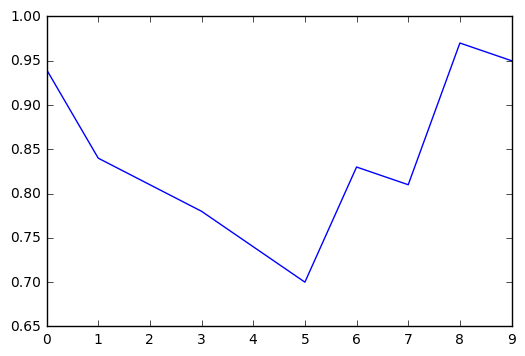

In [5]:
show_performance(encoder,x_test,100)

        eh 	         el
    kecske 	     keréze
     kutya 	      mitja
     aytuk 	      anták
    macska 	     vanája
 árvíztűrő 	  kitsstért
      fúró 	        áró
     kacsa 	      larsa
         a 	          a
        és 	         és

Accuracy on data:  76.0 %


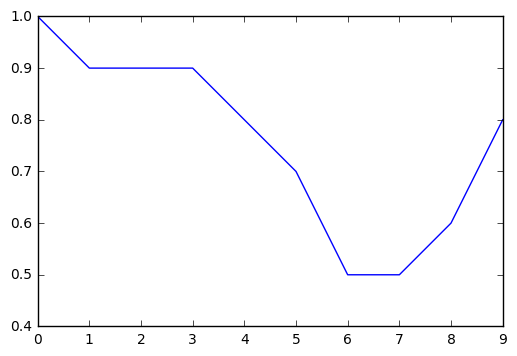

In [6]:
show_performance(encoder,["eh","kecske","kutya","aytuk","macska","árvíztűrő","fúró","kacsa","a","és"])